# 1. **Problem and Objectives**

This research aims to develop an accurate skin disease detection system for three skin disease classes. The approach involves generating synthetic images using StyleGAN2 to augment the dataset and leveraging a CNN-based classifier for disease detection.

### Environment Setup

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
import sys
sys.path.append('/content/stylegan2-ada-pytorch')
import dnnlib
import legacy

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128 (from 1)
Receiving objects: 100% (131/131), 1.13 MiB | 7.72 MiB/s, done.
Resolving deltas: 100% (57/57), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00


# 2. Data Understanding

### Exploring Dataset

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Dataset Path
dataset_path = '/content/drive/MyDrive/Thesis/Dataset'

# Mapping class names to actual disease names
class_name_mapping = {
    "class0": "Eczema",
    "class1": "Psoriasis",
    "class2": "Tinea, Ringworm, Candidiasis, and Other Fungal Infections"
}

classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Count Images per Class
image_count = Counter()
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    if class_name in class_name_mapping:  # Check if folder name has a mapped disease name
        disease_name = class_name_mapping[class_name]
        image_count[disease_name] = len([img for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))])

print("Image Count by Disease Class:")
for disease, count in image_count.items():
    print(f"{disease}: {count} images")




Image Count by Disease Class:
Eczema: 1544 images
Psoriasis: 1757 images
Tinea, Ringworm, Candidiasis, and Other Fungal Infections: 1625 images


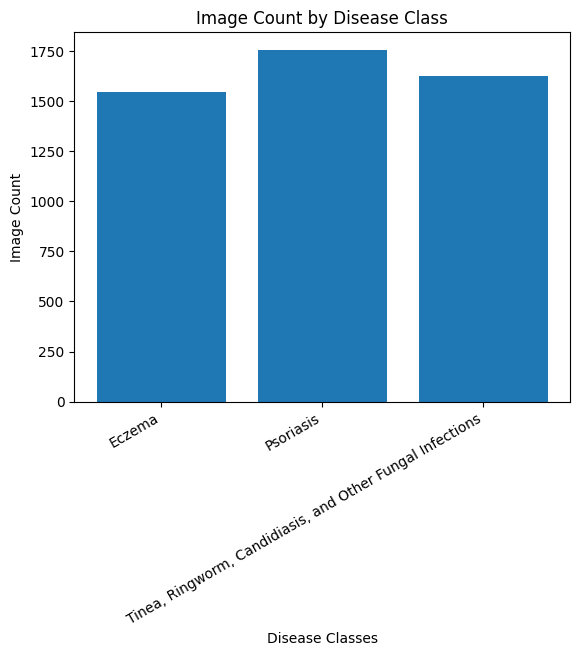

In [ ]:
# Visualizing the data
plt.bar(image_count.keys(), image_count.values())
plt.xticks(rotation=30, ha='right')
plt.xlabel("Disease Classes")
plt.ylabel("Image Count")
plt.title("Image Count by Disease Class")
plt.show()

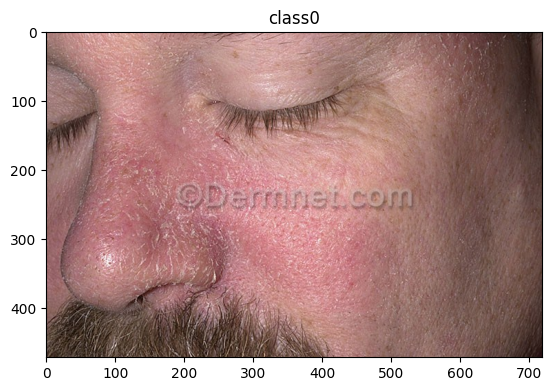

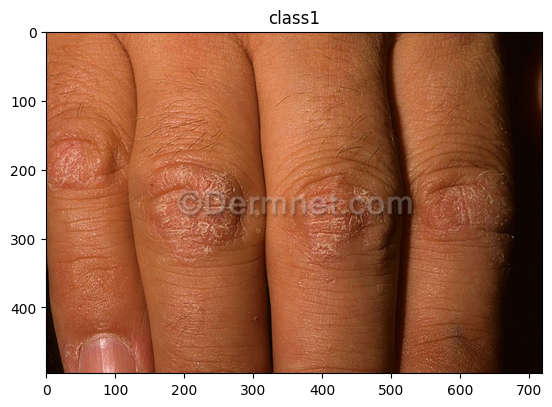

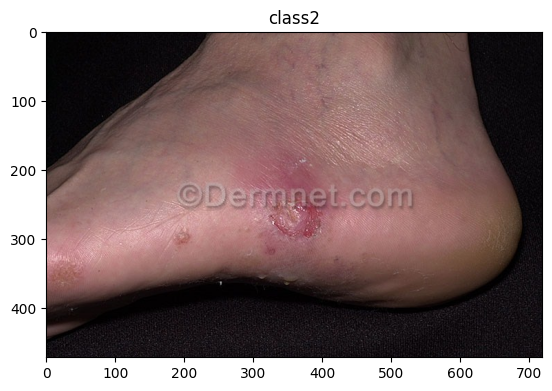

In [ ]:
# Visualizing Sample Images
from PIL import Image
for class_name in classes:
    sample_image = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
    img = Image.open(sample_image)
    plt.imshow(img)
    plt.title(class_name)
    plt.show()

# 3. Data Preprocessing

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define Transformations
transform = transforms.Compose([
    transforms.Resize(1024),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.CenterCrop(1024),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Dataset
from torch.utils.data import Dataset
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'class': class_idx
        }

dataset = SkinDiseaseDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)


# 4. Model Design

In [ ]:
stylegan_path = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
import sys
sys.path.append('/content/stylegan2-ada-pytorch')
import dnnlib
import legacy

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128 (from 1)
Receiving objects: 100% (131/131), 1.13 MiB | 5.05 MiB/s, done.
Resolving deltas: 100% (57/57), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.1 MB/s eta 0:00:00


In [ ]:
########################################################
###############################################################
#############################################################
##############################################################

#### Environment and Imports Setup

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm import tqdm
import dnnlib
import legacy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.nn.functional as F
import torch
import torchvision.models as models
from torchvision.models import inception_v3
import lpips
from torchmetrics.image.fid import FrechetInceptionDistance
import copy
# For inception score
from torchvision.models import inception_v3
import torch.nn.functional as F

DATA_DIR = '/content/drive/MyDrive/Thesis/Dataset'
OUTPUT_DIR = 'output'
BATCH_SIZE = 8
NUM_WORKERS = 2
STYLEGAN_PATH = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
NUM_EPOCHS = 100
NUM_CLASSES = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# directories to store sample and checkpoints
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/samples', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/checkpoints', exist_ok=True)


Dataset Classes

In [ ]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            'image': image.clone().type(torch.float32),
            'class': torch.tensor(class_idx, dtype=torch.long)
        }

3. Discriminator and Generator

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        ).cuda().float()

        self.class_embed = nn.Embedding(num_classes, 512).cuda().float()
        self.adversarial = nn.Linear(1024, 1).cuda().float()
        self.classifier = nn.Linear(1024, num_classes).cuda().float()

    def forward(self, x, target_class):
        features = self.main(x)
        class_embed = self.class_embed(target_class)
        combined = torch.cat([features, class_embed], dim=1)
        return self.adversarial(combined), self.classifier(combined)
class HybridGenerator(nn.Module):
    def __init__(self, stylegan_path, num_classes=3):
        super().__init__()

        # Load StyleGAN2 with explicit dtype handling
        print("Loading StyleGAN2...")
        with dnnlib.util.open_url(stylegan_path) as f:
            G = legacy.load_network_pkl(f)['G_ema']
            # Convert all parameters to float32
            for param in G.parameters():
                param.data = param.data.float()
            self.G = G.eval().cuda()
        print("StyleGAN2 loaded successfully")

        # UNet Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.Conv2d(512, 512, 4, 2, 1)
        ]).cuda()

        # UNet Decoder
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(512 + 512, 512, 4, 2, 1),
            nn.ConvTranspose2d(512 + 256, 256, 4, 2, 1),
            nn.ConvTranspose2d(256 + 128, 128, 4, 2, 1),
            nn.ConvTranspose2d(128 + 64, 64, 4, 2, 1),
            nn.ConvTranspose2d(64 + 3, 3, 4, 2, 1)
        ]).cuda()

        self.class_embed = nn.Embedding(num_classes, 512).cuda()

    def _generate_stylegan_image(self, batch_size):
        try:
            # Generate with explicit dtype handling
            z = torch.randn(batch_size, self.G.z_dim, dtype=torch.float32, device='cuda')
            w = self.G.mapping(z, None, truncation_psi=0.7)
            style_image = self.G.synthesis(w)
            return style_image
        except Exception as e:
            print(f"StyleGAN generation error: {str(e)}")
            # Return a blank image if StyleGAN fails
            return torch.zeros((batch_size, 3, 1024, 1024), dtype=torch.float32, device='cuda')

    def forward(self, x, target_class=None):
        batch_size = x.size(0)

        # UNet forward pass
        features = []
        current = x
        for enc in self.encoder:
            current = F.leaky_relu(enc(current), 0.2)
            features.append(current)

        # Generate StyleGAN image with error handling
        style_image = self._generate_stylegan_image(batch_size)

        # Decode with skip connections
        current = features[-1]
        for i, dec in enumerate(self.decoder):
            if i + 2 <= len(features):
                skip_connection = features[-(i + 2)]
                if skip_connection.shape[2:] != current.shape[2:]:
                    skip_connection = F.interpolate(skip_connection, size=current.shape[2:],
                                                  mode='bilinear', align_corners=True)
                current = F.leaky_relu(dec(torch.cat([current, skip_connection], 1)), 0.2)
            elif i == 4:
                if style_image.shape[2:] != current.shape[2:]:
                    resized_style = F.interpolate(style_image, size=current.shape[2:],
                                                mode='bilinear', align_corners=True)
                else:
                    resized_style = style_image
                current = F.leaky_relu(dec(torch.cat([current, resized_style], 1)), 0.2)
            else:
                current = F.leaky_relu(dec(current), 0.2)

        return torch.tanh(current)

4. Training Loop

In [ ]:
class SkinGANTrainer:
    def __init__(self, data_dir, stylegan_path, batch_size=8):
        self.device = torch.device('cuda')

        # Set default tensor type to float32
        torch.set_default_tensor_type(torch.FloatTensor)
            # Set default tensor type
        torch.set_default_tensor_type(torch.FloatTensor)

        # Enable TF32 for better performance
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)

        transform = transforms.Compose([
            transforms.Resize(1024),
            transforms.CenterCrop(1024),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        dataset = SkinDiseaseDataset(data_dir, transform=transform)
        self.dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            drop_last=True
        )

        # Initialize networks with explicit dtype
        self.netG = HybridGenerator(stylegan_path).cuda().float()
        self.netD = Discriminator().cuda().float()

        # Modified optimizer settings
        base_lr_g = 0.0001  # Reduced learning rate
        base_lr_d = 0.000025  # Reduced from 0.00005
        self.optimD = optim.AdamW(
            self.netD.parameters(),
            lr=base_lr_d,
            betas=(0.5, 0.999),
            weight_decay=0.01
        )
        self.optimG = optim.AdamW([  # Changed to AdamW
            {'params': [p for m in self.netG.encoder for p in m.parameters()], 'lr': base_lr_g},
            {'params': [p for m in self.netG.decoder for p in m.parameters()], 'lr': base_lr_g},
            {'params': self.netG.class_embed.parameters(), 'lr': base_lr_g}
        ], betas=(0.5, 0.999), weight_decay=0.01)

        # Add learning rate schedulers
        self.scheduler_g = ReduceLROnPlateau(self.optimG, mode='min', factor=0.5, patience=5, min_lr=1e-6)
        self.scheduler_d = ReduceLROnPlateau(self.optimD, mode='min', factor=0.5, patience=5, min_lr=1e-6)

        # Loss weights
        self.lambda_content = 5.0  # Reduced from 10.0
        self.lambda_feature = 0.5
        self.lambda_gp = 15.0  # For gradient penalty

        # Basic losses
        self.criterion_adv = nn.BCEWithLogitsLoss()
        self.criterion_cls = nn.CrossEntropyLoss()
        self.content_loss = nn.L1Loss()
        self.feature_loss = nn.MSELoss()

        # Add gradient scalers for mixed precision training
        self.scaler_g = torch.cuda.amp.GradScaler()
        self.scaler_d = torch.cuda.amp.GradScaler()
        self.ema_netG = copy.deepcopy(self.netG).eval()
        self.ema_netG.requires_grad_(False)
        self.ema_decay = 0.999
        self.warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimG, lr_lambda=lambda epoch: min(1.0, epoch / 10)
        )

    def discriminator_loss(self, real_logits, fake_logits):
        real_loss = torch.mean(F.relu(1.0 - real_logits))
        fake_loss = torch.mean(F.relu(1.0 + fake_logits))
        return real_loss + fake_loss

    def generator_loss(self, fake_logits):
        return -torch.mean(fake_logits)



    def update_ema(self):
        """Update EMA weights for the generator."""
        for ema_param, param in zip(self.ema_netG.parameters(), self.netG.parameters()):
            ema_param.data = self.ema_decay * ema_param.data + (1 - self.ema_decay) * param.data
    def compute_gradient_penalty(self, real_samples, fake_samples):
        """Compute gradient penalty for stable training"""
        alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(self.device)
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

        d_interpolates, _ = self.netD(interpolates, torch.zeros(real_samples.size(0)).long().to(self.device))

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_step(self, real_images, real_classes):
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            # Train D
            torch.nn.utils.clip_grad_norm_(self.netD.parameters(), max_norm=1.0)
            self.optimD.zero_grad(set_to_none=True)
            real_validity, real_pred = self.netD(real_images, real_classes)
            d_real_loss = self.criterion_adv(real_validity, real_labels)
            d_class_loss = self.criterion_cls(real_pred, real_classes)

            # Generate fake images first
            fake_images = self.netG(real_images, real_classes)
            fake_validity, _ = self.netD(fake_images.detach(), real_classes)
            d_fake_loss = self.criterion_adv(fake_validity, fake_labels)

            d_loss = d_real_loss + d_fake_loss + 0.5 * d_class_loss
            d_loss.backward(retain_graph=True)  # Added retain_graph=True
            self.optimD.step()

            # Train G
            torch.nn.utils.clip_grad_norm_(self.netG.parameters(), max_norm=1.0)

            self.optimG.zero_grad(set_to_none=True)
            fake_validity, fake_pred = self.netD(fake_images, real_classes)
            g_adv = self.criterion_adv(fake_validity, real_labels)
            g_cls = self.criterion_cls(fake_pred, real_classes)
            g_content = self.content_loss(fake_images, real_images)

            g_loss = 1.0 * g_adv + 1.0 * g_cls + self.lambda_content * g_content
            g_loss.backward()  # No need for retain_graph here as it's the last backward
            self.optimG.step()

            # Detach for memory efficiency
            del fake_images
            torch.cuda.empty_cache()
            # After optimG.step()
            self.update_ema()
            self.warmup_scheduler.step()
            self.scheduler_g.step(g_loss.item())
            self.scheduler_d.step(d_loss.item())

            return d_loss.item(), g_loss.item()

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            pbar = tqdm(self.dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_d_loss = 0
            epoch_g_loss = 0

            for i, batch in enumerate(pbar):
                real_images = batch['image'].cuda()
                real_classes = batch['class'].cuda()

                d_loss, g_loss = self.train_step(real_images, real_classes)

                epoch_d_loss += d_loss
                epoch_g_loss += g_loss

                if i % 100 == 0:
                    lr_g = self.optimG.param_groups[0]['lr']
                    lr_d = self.optimD.param_groups[0]['lr']

                    pbar.set_postfix({
                        'D': f'{d_loss:.4f}',
                        'G': f'{g_loss:.4f}',
                        'LR_G': f'{lr_g:.6f}',
                        'LR_D': f'{lr_d:.6f}'
                    })

            avg_d_loss = epoch_d_loss / len(self.dataloader)
            avg_g_loss = epoch_g_loss / len(self.dataloader)

            print(f"\nEpoch {epoch+1} - Avg D: {avg_d_loss:.4f}, Avg G: {avg_g_loss:.4f}")

            if (epoch + 1) % 2 == 0:
                self.save_samples(epoch + 1)
                self.show_generated_samples(epoch + 1)
            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(epoch + 1)

            ## Evaluating FID score
            # if (epoch + 1) % 2 == 0:
            #     with torch.no_grad():
            #         metrics = self.evaluate_model(epoch + 1)
            #         print(f"Epoch {epoch+1} Metrics:", metrics)



    def save_samples(self, epoch):
        self.netG.eval()
        with torch.no_grad():
            samples = []
            for class_idx in range(3):
                class_tensor = torch.full((4,), class_idx, dtype=torch.long, device=self.device)
                real_images = next(iter(self.dataloader))['image'][:4].cuda()
                fake = self.netG(real_images, class_tensor)
                samples.append(fake)

            samples = torch.cat(samples, dim=0)
            vutils.save_image(samples, f'{OUTPUT_DIR}/samples/epoch_{epoch}.png', normalize=True, nrow=4)
        self.netG.train()


    def save_checkpoint(self, epoch):
        torch.save({
            'epoch': epoch,
            'netG_state': self.netG.state_dict(),
            'netD_state': self.netD.state_dict(),
            'optimG_state': self.optimG.state_dict(),
            'optimD_state': self.optimD.state_dict(),
        }, f'checkpoints/epoch_{epoch}.pt')

    def generate_fake_images(self):
        self.netG.eval()
        fake_images = []
        with torch.no_grad():
            for _ in range(len(self.dataloader)):
                real_batch = next(iter(self.dataloader))
                real_images = real_batch['image'].to(DEVICE)
                fake_images.append(self.netG(real_images, torch.randint(0, NUM_CLASSES, (real_images.size(0),)).to(DEVICE)))
        self.netG.train()

        # Create a DataLoader for generated images
        fake_dataset = torch.utils.data.TensorDataset(torch.cat(fake_images, dim=0))
        fake_loader = DataLoader(fake_dataset, batch_size=BATCH_SIZE)
        del fake_images
        torch.cuda.empty_cache()
        return fake_loader

    def evaluate_fid(self, real_loader, fake_loader):
        # Initialize FID module
        fid = FrechetInceptionDistance(feature=2048, normalize=True).to(self.device)

        with torch.no_grad():
            # Process real images
            for real_batch in tqdm(real_loader, desc="Processing real images"):
                real_images = real_batch['image'].to(self.device)
                # Ensure images are in correct range [0, 1]
                real_images = (real_images + 1) / 2
                fid.update(real_images, real=True)

            # Process fake images
            for fake_batch in tqdm(fake_loader, desc="Processing fake images"):
                fake_images = fake_batch['image'].to(self.device)
                fake_images = (fake_images + 1) / 2
                fid.update(fake_images, real=False)
        del fake_images
        torch.cuda.empty_cache()
        return fid.compute().item()


    def calculate_inception_score(self, fake_loader):
        inception_model = inception_v3(pretrained=True, transform_input=False).to(self.device)
        inception_model.eval()

        predictions = []
        with torch.no_grad():
            for fake_batch in tqdm(fake_loader, desc="Calculating IS"):
                fake_images = fake_batch['image'].to(self.device)
                # Resize to inception input size
                fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear')
                pred = F.softmax(inception_model(fake_images), dim=1)
                predictions.append(pred.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)

        # Calculate mean kl-divergence
        py = np.mean(predictions, axis=0)
        scores = []
        for p in predictions:
            kl_d = p * (np.log(p + 1e-10) - np.log(py + 1e-10))
            kl_d = np.sum(kl_d)
            scores.append(np.exp(kl_d))
        del fake_images
        torch.cuda.empty_cache()
        return np.mean(scores), np.std(scores)

    def calculate_lpips(self, real_loader, fake_loader):
        lpips_model = lpips.LPIPS(net='alex').to(self.device)
        lpips_scores = []

        with torch.no_grad():
            for (real_batch, fake_batch) in zip(real_loader, fake_loader):
                real_images = real_batch['image'].to(self.device)
                fake_images = fake_batch['image'].to(self.device)

                # Normalize to [-1,1]
                real_images = (real_images + 1) / 2
                fake_images = (fake_images + 1) / 2

                distance = lpips_model(real_images, fake_images)
                lpips_scores.append(distance.mean().item())
        del fake_images
        torch.cuda.empty_cache()
        return np.mean(lpips_scores)

    def calculate_diversity(self, fake_loader, num_pairs=1000):
        features = []
        inception = models.inception_v3(pretrained=True, transform_input=False).to(self.device)
        inception.eval()

        with torch.no_grad():
            for batch in fake_loader:
                images = batch['image'].to(self.device)
                images = F.interpolate(images, size=(299, 299), mode='bilinear')
                feat = inception(images).cpu().numpy()
                features.append(feat)

        features = np.concatenate(features, axis=0)

        # Calculate pairwise distances
        indices = np.random.choice(len(features), size=(2, num_pairs))
        distances = np.sqrt(((features[indices[0]] - features[indices[1]]) ** 2).sum(axis=1))

        return distances.mean()

    def evaluate_classification_accuracy(self, fake_loader, classifier):
        classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in fake_loader:
                images = batch['image'].to(self.device)
                labels = batch['class'].to(self.device)

                outputs = classifier(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return 100 * correct / total

    def evaluate_model(self, epoch):
        # Create loaders
        real_loader = DataLoader(self.dataloader.dataset, batch_size=self.dataloader.batch_size, shuffle=False)
        fake_loader = self.generate_fake_images()

        metrics = {}
        metrics['fid'] = self.evaluate_fid(real_loader, fake_loader)
        metrics['inception_score'] = self.calculate_inception_score(fake_loader)
        #metrics['lpips'] = self.calculate_lpips(real_loader, fake_loader)
        #metrics['diversity'] = self.calculate_diversity(fake_loader)
        del real_loader
        del fake_loader
        torch.cuda.empty_cache()
        return metrics


    def show_generated_samples(self, epoch):
        """
        Display generated samples in the notebook and save them to disk.
        """
        self.netG.eval()
        with torch.no_grad():
            real_batch = next(iter(self.dataloader))
            real_images = real_batch['image'][:4].to(DEVICE)  # Take a few real images
            fake_images = self.netG(real_images, torch.randint(0, NUM_CLASSES, (real_images.size(0),)).to(DEVICE))

        # Save generated samples
        vutils.save_image(fake_images, f'{OUTPUT_DIR}/samples/epoch_{epoch}.png', normalize=True, nrow=4)

        # Convert tensor to image for display
        grid = vutils.make_grid(fake_images, normalize=True, nrow=4)
        np_grid = grid.permute(1, 2, 0).cpu().numpy()

        # Display images inline
        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.axis('off')
        plt.title(f'Generated Samples - Epoch {epoch}')
        plt.show()

## Training Hybrid Model (SkinGan2+Unet)

In [ ]:
if __name__ == "__main__":
    sys.path.append('stylegan2-ada-pytorch')
    trainer = SkinGANTrainer(
        data_dir=DATA_DIR,
        stylegan_path=STYLEGAN_PATH,
        batch_size=8
    )
    trainer.train(num_epochs=100)

Output hidden; open in https://colab.research.google.com to view.

## Generating Samples for each class of Skin dieses

# Generating Synthetic Images

In [ ]:

class SkinGANTrainer:
    def __init__(self, data_dir, stylegan_path, batch_size=4):
        self.device = torch.device('cuda')
        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)

        transform = transforms.Compose([
            transforms.Resize(1024),
            transforms.CenterCrop(1024),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        dataset = SkinDiseaseDataset(data_dir, transform=transform)
        self.dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            drop_last=True
        )

        self.netG = HybridGenerator(stylegan_path).cuda()
        self.netD = Discriminator().cuda()

        # Fix optimizer initialization
        self.optimG = optim.Adam([
            {'params': [p for m in self.netG.encoder for p in m.parameters()]},
            {'params': [p for m in self.netG.decoder for p in m.parameters()]},
            {'params': self.netG.class_embed.parameters()}
        ], lr=0.0001, betas=(0.5, 0.999))

        self.optimD = optim.Adam(self.netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion_adv = nn.BCEWithLogitsLoss()
        self.criterion_cls = nn.CrossEntropyLoss()

        # Additional losses
        self.content_loss = nn.L1Loss()
        self.feature_loss = nn.MSELoss()

    def train_step(self, real_images, real_classes):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # Train D
        self.optimD.zero_grad(set_to_none=True)
        real_validity, real_pred = self.netD(real_images, real_classes)
        fake_images = self.netG(real_images, real_classes)

        d_real_loss = self.criterion_adv(real_validity, real_labels)
        d_real_cls = self.criterion_cls(real_pred, real_classes)

        fake_validity, _ = self.netD(fake_images.detach(), real_classes)
        d_fake_loss = self.criterion_adv(fake_validity, fake_labels)

        d_loss = d_real_loss + d_fake_loss + d_real_cls
        d_loss.backward()
        self.optimD.step()

        # Train G
        self.optimG.zero_grad(set_to_none=True)
        fake_validity, fake_pred = self.netD(fake_images, real_classes)

        g_adv = self.criterion_adv(fake_validity, real_labels)
        g_cls = self.criterion_cls(fake_pred, real_classes)
        g_content = self.content_loss(fake_images, real_images)

        g_loss = g_adv + g_cls + 10.0 * g_content
        g_loss.backward()
        self.optimG.step()

        return d_loss.item(), g_loss.item()

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            pbar = tqdm(self.dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for batch in pbar:
                real_images = batch['image'].cuda()
                real_classes = batch['class'].cuda()

                d_loss, g_loss = self.train_step(real_images, real_classes)
                pbar.set_postfix({'D': f'{d_loss:.4f}', 'G': f'{g_loss:.4f}'})

            if (epoch + 1) % 2 == 0:
                self.save_samples(epoch + 1)
            if (epoch+1) % 10 ==0:
                self.save_checkpoint(epoch + 1)

    def save_samples(self, epoch):
        self.netG.eval()
        with torch.no_grad():
            samples = []
            for class_idx in range(3):
                class_tensor = torch.full((4,), class_idx, dtype=torch.long, device=self.device)
                real_images = next(iter(self.dataloader))['image'][:4].cuda()
                fake = self.netG(real_images, class_tensor)
                samples.append(fake)

            samples = torch.cat(samples, dim=0)
            vutils.save_image(samples, f'samples/epoch_{epoch}.png', normalize=True, nrow=4)
        self.netG.train()

    def load_checkpoint(self, path):
        checkpoint = torch.load(path)
        self.netG.load_state_dict(checkpoint['netG_state'])
        self.netD.load_state_dict(checkpoint['netD_state'])
        self.optimG.load_state_dict(checkpoint['optimG_state'])
        self.optimD.load_state_dict(checkpoint['optimD_state'])
        return checkpoint['epoch']

    def save_checkpoint(self, epoch):
        torch.save({
            'epoch': epoch,
            'netG_state': self.netG.state_dict(),
            'netD_state': self.netD.state_dict(),
            'optimG_state': self.optimG.state_dict(),
            'optimD_state': self.optimD.state_dict(),
        }, f'checkpoints/epoch_{epoch}.pt')

    def generate_images(self, class_idx, num_images, source_images=None, output_path='generated_samples'):
        """
        Generate images for a specific class using real source images or first batch from dataloader

        Args:
            class_idx (int): Class index (0, 1, 2) to generate images for
            num_images (int): Number of images to generate
            source_images: Optional source images to use as base
            output_path (str): Directory to save generated images
        """
        os.makedirs(output_path, exist_ok=True)
        self.netG.eval()

        with torch.no_grad():
            # If no source images provided, use first batch from dataloader
            if source_images is None:
                source_images = next(iter(self.dataloader))['image'].cuda()

            # Generate images in batches of 4
            num_batches = (num_images + 3) // 4
            generated_images = []

            for i in tqdm(range(num_batches)):
                batch_size = min(4, num_images - i * 4)

                # Use cyclic indexing for source images
                batch_source = source_images[:(batch_size)]
                class_labels = torch.full((batch_size,), class_idx, dtype=torch.long).cuda()

                # Generate images using source images instead of random noise
                fake_images = self.netG(batch_source, class_labels)

                # Save individual images
                for j in range(batch_size):
                    img_tensor = fake_images[j]
                    img_tensor = (img_tensor + 1) / 2.0
                    img_tensor = torch.clamp(img_tensor, 0, 1)

                    img = transforms.ToPILImage()(img_tensor.cpu())
                    img.save(f'{output_path}/class_{class_idx}_sample_{i*4+j+1}.png')

                generated_images.append(fake_images)

            # Create grid
            all_images = torch.cat(generated_images, dim=0)[:num_images]
            grid = vutils.make_grid(all_images, nrow=min(8, num_images), normalize=True)
            grid_img = transforms.ToPILImage()(grid)
            grid_img.save(f'{output_path}/class_{class_idx}_grid.png')

        self.netG.train()
        print(f'Generated {num_images} images for class {class_idx}')


In [ ]:
import torch
import os
import torch.utils.data as data
from torchvision import transforms, utils as vutils
from tqdm import tqdm
from PIL import Image
import gc
import random
import numpy as np
import matplotlib.pyplot as plt

def generate_large_scale_images(trainer, images_per_class=2000, batch_size=8, output_base_dir='generated_dataset'):
    """
    Generate diverse images using random noise and source image variations
    """
    os.makedirs(output_base_dir, exist_ok=True)
    trainer.netG.eval()

    # Create an iterator for the dataloader to cycle through different source images
    dataset_iterator = iter(trainer.dataloader)

    with torch.no_grad():
        for class_idx in range(3):
            print(f"\nGenerating {images_per_class} images for class {class_idx}")

            class_dir = os.path.join(output_base_dir, f'class_{class_idx}')
            os.makedirs(class_dir, exist_ok=True)

            num_batches = (images_per_class + batch_size - 1) // batch_size

            for batch_idx in tqdm(range(num_batches)):
                current_batch_size = min(batch_size, images_per_class - batch_idx * batch_size)

                # Get new source images for each batch
                try:
                    source_batch = next(dataset_iterator)
                    source_images = source_batch['image'].cuda()
                except StopIteration:
                    # Restart iterator when we reach the end of dataset
                    dataset_iterator = iter(trainer.dataloader)
                    source_batch = next(dataset_iterator)
                    source_images = source_batch['image'].cuda()

                # Add random noise to source images for variation
                noise = torch.randn_like(source_images) * 0.1
                source_images = source_images + noise
                source_images = torch.clamp(source_images, -1, 1)

                # Take only the needed number of images from the batch
                source_images = source_images[:current_batch_size]

                # Generate class labels
                class_labels = torch.full((current_batch_size,), class_idx,
                                       dtype=torch.long, device='cuda')

                try:
                    # Generate images
                    fake_images = trainer.netG(source_images, class_labels)

                    # Process and save each image in the batch
                    for i in range(current_batch_size):
                        img_tensor = fake_images[i]
                        img_tensor = (img_tensor + 1) / 2.0
                        img_tensor = torch.clamp(img_tensor, 0, 1)

                        img = transforms.ToPILImage()(img_tensor.cpu())

                        # Add random identifier to prevent overwriting
                        random_id = random.randint(0, 9999)
                        img_path = os.path.join(class_dir,
                                              f'img_{batch_idx * batch_size + i:05d}_{random_id}.png')
                        img.save(img_path, quality=95)

                    del fake_images
                    torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error generating batch {batch_idx}: {str(e)}")
                    continue

                if batch_idx % 100 == 0:
                    gc.collect()

            print(f"Creating sample grid for class {class_idx}")
            create_sample_grid(class_dir, output_base_dir, class_idx)

    trainer.netG.train()
    print("\nImage generation completed!")

def create_sample_grid(class_dir, output_base_dir, class_idx, num_samples=64):
    """Create a grid visualization of random samples"""
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]

    if len(image_files) == 0:
        print(f"No images found in {class_dir}")
        return

    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    sample_tensors = []
    transform = transforms.ToTensor()

    for file in sample_files:
        img_path = os.path.join(class_dir, file)
        img = Image.open(img_path)
        sample_tensors.append(transform(img))

    samples = torch.stack(sample_tensors)
    grid = vutils.make_grid(samples, nrow=8, padding=2, normalize=True)
    grid_img = transforms.ToPILImage()(grid)
    grid_img.save(os.path.join(output_base_dir, f'class_{class_idx}_samples_grid.png'))

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # Convert CHW to HWC for displaying
    plt.axis('off')  # Turn off axes
    plt.title(f"Class {class_idx} Sample Grid")
    plt.show()

# Usage
if __name__ == "__main__":
    # Set random seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    np.random.seed(42)

    trainer = SkinGANTrainer(
        data_dir='/content/drive/MyDrive/Thesis/Dataset',
        stylegan_path='https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl',
        batch_size=8
    )

    trainer.load_checkpoint('/content/checkpoints/epoch_50.pt')

    generate_large_scale_images(
        trainer=trainer,
        images_per_class=1000,
        batch_size=8,
        output_base_dir='/content/drive/MyDrive/Thesis/synthetic_images'
    )

Output hidden; open in https://colab.research.google.com to view.

# Skin Disease Classification

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime

# EfficientNet-Based Skin Disease Classifier


## 1. Imports

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

### 2. Data Preprocessing

In [ ]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, files: List[str], labels: List[int], transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = torch.zeros((3, 300, 300))

        return image, label

In [ ]:
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    folder_mapping = {"class_0": "class0", "class_1": "class1", "class_2": "class2"}
    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_files.extend(files)
        all_labels.extend([class_folder] * len(files))
        print(f"Loaded {len(files)} images from {class_folder}")

    # Debug print
    print("\nChecking GAN dataset path:", generated_path)
    print("Available directories in GAN path:", os.listdir(generated_path))

    # Load GAN-generated images with better error handling
    print("\nLoading GAN-generated images...")
    for orig_folder, gan_folder in folder_mapping.items():
        gan_path = os.path.join(generated_path, gan_folder)
        print(f"Checking path: {gan_path}")

        if os.path.exists(gan_path):
            if os.path.isdir(gan_path):
                files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)]
                all_files.extend(files)
                all_labels.extend([orig_folder] * len(files))
                print(f"Loaded {len(files)} synthetic images for {orig_folder}")
            else:
                print(f"Path exists but is not a directory: {gan_path}")
        else:
            print(f"Path does not exist: {gan_path}")

    # Show class distribution
    class_dist = {cls: all_labels.count(cls) for cls in set(all_labels)}
    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"{cls}: {count} images")

    # Encode labels
    unique_classes = sorted(set(all_labels))
    label_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    encoded_labels = [label_to_idx[label] for label in all_labels]

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, encoded_labels, test_size=test_size, random_state=42, stratify=encoded_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, unique_classes
# Execute preprocessing
train_files, test_files, train_labels, test_labels, class_names = load_and_split_data(
    original_dataset_path, gan_generated_path
)


STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class0
Loaded 1757 images from class1
Loaded 1625 images from class2

Checking GAN dataset path: /content/drive/MyDrive/Thesis/synthetic_images
Available directories in GAN path: ['class_0_samples_grid.png', 'class_1_samples_grid.png', 'class_2_samples_grid.png', 'class2', 'class1', 'class0']

Loading GAN-generated images...
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class0
Loaded 1000 synthetic images for class_0
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class1
Loaded 1000 synthetic images for class_1
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class2
Loaded 1000 synthetic images for class_2

Class distribution:
class_1: 1000 images
class_2: 1000 images
class1: 1757 images
class2: 1625 images
class_0: 1000 images
class0: 1544 images

Split complete:
Train samples: 6340
Test samples: 1586


### 3. Data Loaders

In [ ]:
def get_dataloaders(train_files, test_files, train_labels, test_labels,
                    img_size=(300, 300), batch_size=32):
    print("\nSTAGE 2: DATA LOADING AND AUGMENTATION")
    print("="*50)

    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {len(train_loader)}")

    return train_loader, test_loader

# Create dataloaders
train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)


STAGE 2: DATA LOADING AND AUGMENTATION
Batch size: 32
Steps per epoch: 199


### 4. Model Setup

In [ ]:
def get_model(num_classes):
    print("\nSTAGE 3: MODEL ARCHITECTURE")
    print("="*50)

    model = efficientnet_b5(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel Statistics:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

# Setup model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


STAGE 3: MODEL ARCHITECTURE


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Model Statistics:
Total parameters: 28,353,078
Trainable parameters: 28,353,078


### 5.Training

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, device, epochs=60):
    print("\nSTAGE 4: TRAINING")
    print("="*50)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    model = model.to(device)
    print(f"\nModel moved to {device}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                print(f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.2f}%")
            torch.save(model.state_dict(), 'best_model.pth')

    return history


# Train the model
history = train_model(model, train_loader, test_loader, criterion,
                     optimizer, scheduler, device)


STAGE 4: TRAINING

Model moved to cuda

Epoch 1/60
--------------------
Batch: 0/199 | Loss: 1.7962
Batch: 20/199 | Loss: 1.7801
Batch: 40/199 | Loss: 1.7546
Batch: 60/199 | Loss: 1.6984
Batch: 80/199 | Loss: 1.7535
Batch: 100/199 | Loss: 1.5727
Batch: 120/199 | Loss: 1.5659
Batch: 140/199 | Loss: 1.5462
Batch: 160/199 | Loss: 1.3961
Batch: 180/199 | Loss: 1.3470

Epoch Summary:
Train Loss: 1.6173 | Train Acc: 29.40%
Val Loss: 1.4667 | Val Acc: 38.15%
New best validation accuracy: 38.15%

Epoch 2/60
--------------------
Batch: 0/199 | Loss: 1.5020
Batch: 20/199 | Loss: 1.3264
Batch: 40/199 | Loss: 1.4730
Batch: 60/199 | Loss: 1.4445
Batch: 80/199 | Loss: 1.2016
Batch: 100/199 | Loss: 1.6308
Batch: 120/199 | Loss: 1.3309
Batch: 140/199 | Loss: 1.3321
Batch: 160/199 | Loss: 1.3636
Batch: 180/199 | Loss: 1.2910

Epoch Summary:
Train Loss: 1.3519 | Train Acc: 39.26%
Val Loss: 1.1359 | Val Acc: 47.79%
New best validation accuracy: 47.79%

Epoch 3/60
--------------------
Batch: 0/199 | Loss

### 6. Evaluation


STAGE 5: EVALUATION

Classification Report:

class0:
Precision: 0.7847
Recall: 0.8608
F1-score: 0.8210

class1:
Precision: 0.8562
Recall: 0.7614
F1-score: 0.8060

class2:
Precision: 0.8069
Recall: 0.8615
F1-score: 0.8333

class_0:
Precision: 0.3155
Recall: 0.2650
F1-score: 0.2880

class_1:
Precision: 0.3297
Recall: 0.4500
F1-score: 0.3805

class_2:
Precision: 0.3356
Recall: 0.2450
F1-score: 0.2832

Overall Accuracy: 0.6343


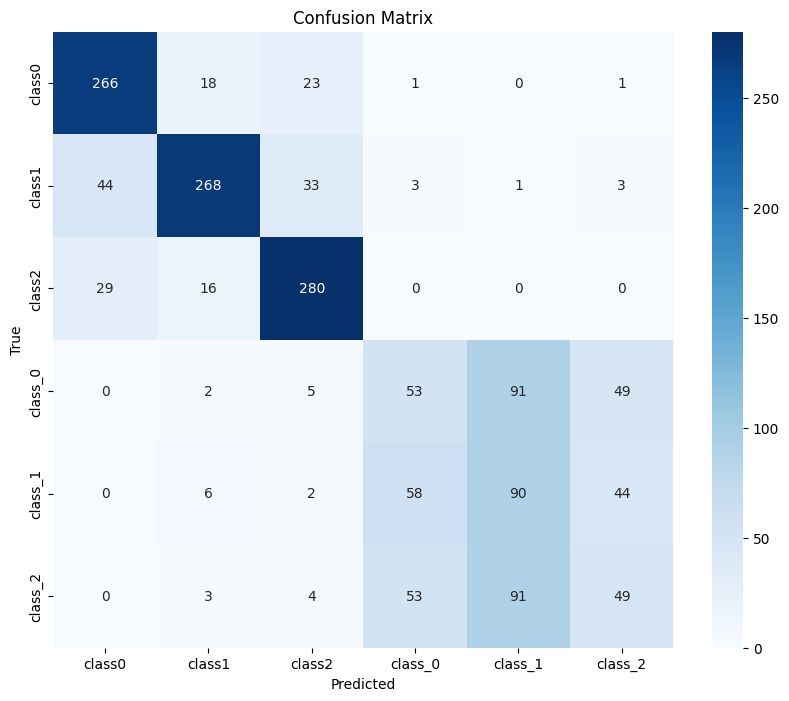

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    print("\nSTAGE 5: EVALUATION")
    print("="*50)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names,
                                 output_dict=True)

    for class_name in class_names:
        metrics = report[class_name]
        print(f"\n{class_name}:")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report

model = model.to(device)
# Evaluate the model
evaluation_report = evaluate_model(model, test_loader, device, class_names)

# Using CNN Model

### 1. Imports

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

# Set paths
original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

### 2.Dataset CLass

In [ ]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, files:[], labels: [], transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = torch.zeros((3, 300, 300))

        return image, label

### 3. Data Preprocessing

In [ ]:
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    folder_mapping = {"class_0": "class0", "class_1": "class1", "class_2": "class2"}
    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_files.extend(files)
        all_labels.extend([class_folder] * len(files))
        print(f"Loaded {len(files)} images from {class_folder}")

    # Debug print
    print("\nChecking GAN dataset path:", generated_path)
    print("Available directories in GAN path:", os.listdir(generated_path))

    # Load GAN-generated images with better error handling
    print("\nLoading GAN-generated images...")
    for orig_folder, gan_folder in folder_mapping.items():
        gan_path = os.path.join(generated_path, gan_folder)
        print(f"Checking path: {gan_path}")

        if os.path.exists(gan_path):
            if os.path.isdir(gan_path):
                files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)]
                all_files.extend(files)
                all_labels.extend([orig_folder] * len(files))
                print(f"Loaded {len(files)} synthetic images for {orig_folder}")
            else:
                print(f"Path exists but is not a directory: {gan_path}")
        else:
            print(f"Path does not exist: {gan_path}")

    # Show class distribution
    class_dist = {cls: all_labels.count(cls) for cls in set(all_labels)}
    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"{cls}: {count} images")

    # Encode labels
    unique_classes = sorted(set(all_labels))
    label_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    encoded_labels = [label_to_idx[label] for label in all_labels]

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, encoded_labels, test_size=test_size, random_state=42, stratify=encoded_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, unique_classes
# Execute preprocessing
train_files, test_files, train_labels, test_labels, class_names = load_and_split_data(
    original_dataset_path, gan_generated_path
)


STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class0
Loaded 1757 images from class1
Loaded 1625 images from class2

Checking GAN dataset path: /content/drive/MyDrive/Thesis/synthetic_images
Available directories in GAN path: ['class_0_samples_grid.png', 'class_1_samples_grid.png', 'class_2_samples_grid.png', 'class2', 'class1', 'class0']

Loading GAN-generated images...
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class0
Loaded 1000 synthetic images for class_0
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class1
Loaded 1000 synthetic images for class_1
Checking path: /content/drive/MyDrive/Thesis/synthetic_images/class2
Loaded 1000 synthetic images for class_2

Class distribution:
class_1: 1000 images
class_2: 1000 images
class1: 1757 images
class2: 1625 images
class_0: 1000 images
class0: 1544 images

Split complete:
Train samples: 6340
Test samples: 1586


### 4. Data Loaders

In [ ]:
def get_dataloaders(train_files, test_files, train_labels, test_labels,
                    img_size=(224, 224), batch_size=32):
    print("\nSTAGE 2: DATA LOADING AND AUGMENTATION")
    print("="*50)

    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {len(train_loader)}")

    return train_loader, test_loader

# Create dataloaders
train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)


STAGE 2: DATA LOADING AND AUGMENTATION
Batch size: 32
Steps per epoch: 199


### 5.CNN Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        print("\nSTAGE 3: MODEL ARCHITECTURE")
        print("="*50)

        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        # Print model summary
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Statistics:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x

# Setup model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


STAGE 3: MODEL ARCHITECTURE

Model Statistics:
Total parameters: 419,936,582
Trainable parameters: 419,936,582


### 6.Training

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, device, epochs=50):
    print("\nSTAGE 4: TRAINING")
    print("="*50)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    model = model.to(device)
    print(f"Model moved to {device}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                print(f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.2f}%")
            torch.save(model.state_dict(), 'best_cnn_model.pth')

    return history

# Train the model
history = train_model(model, train_loader, test_loader, criterion,
                     optimizer, scheduler, device)


STAGE 4: TRAINING
Model moved to cuda

Epoch 1/50
--------------------
Batch: 0/199 | Loss: 1.8350
Batch: 20/199 | Loss: 2.3755
Batch: 40/199 | Loss: 2.5624
Batch: 60/199 | Loss: 1.6892
Batch: 80/199 | Loss: 1.9237
Batch: 100/199 | Loss: 1.8666
Batch: 120/199 | Loss: 1.8473
Batch: 140/199 | Loss: 2.1784
Batch: 160/199 | Loss: 1.7896
Batch: 180/199 | Loss: 1.7816

Epoch Summary:
Train Loss: 4.6126 | Train Acc: 20.88%
Val Loss: 1.9252 | Val Acc: 20.11%
New best validation accuracy: 20.11%

Epoch 2/50
--------------------
Batch: 0/199 | Loss: 1.8129
Batch: 20/199 | Loss: 1.8160
Batch: 40/199 | Loss: 1.7878
Batch: 60/199 | Loss: 1.8161
Batch: 80/199 | Loss: 1.8442
Batch: 100/199 | Loss: 1.7724
Batch: 120/199 | Loss: 1.7627
Batch: 140/199 | Loss: 1.7712
Batch: 160/199 | Loss: 1.6549
Batch: 180/199 | Loss: 1.8090

Epoch Summary:
Train Loss: 1.7905 | Train Acc: 22.16%
Val Loss: 1.7628 | Val Acc: 22.57%
New best validation accuracy: 22.57%

Epoch 3/50
--------------------
Batch: 0/199 | Loss:

### 7.Evaluation


STAGE 5: EVALUATION
Generating predictions...

Per-class Accuracy:
--------------------
class0: 0.00% (0/309)
class1: 99.43% (350/352)
class2: 0.31% (1/325)
class_0: 0.00% (0/200)
class_1: 0.00% (0/200)
class_2: 0.00% (0/200)

Detailed Classification Report:
--------------------

class0:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 309.0

class1:
Precision: 0.2215
Recall: 0.9943
F1-score: 0.3623
Support: 352.0

class2:
Precision: 0.1667
Recall: 0.0031
F1-score: 0.0060
Support: 325.0

class_0:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 200.0

class_1:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 200.0

class_2:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 200.0

Overall Metrics:
--------------------
Accuracy: 0.2213
Macro avg F1-score: 0.0614
Weighted avg F1-score: 0.0817

Generating Confusion Matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


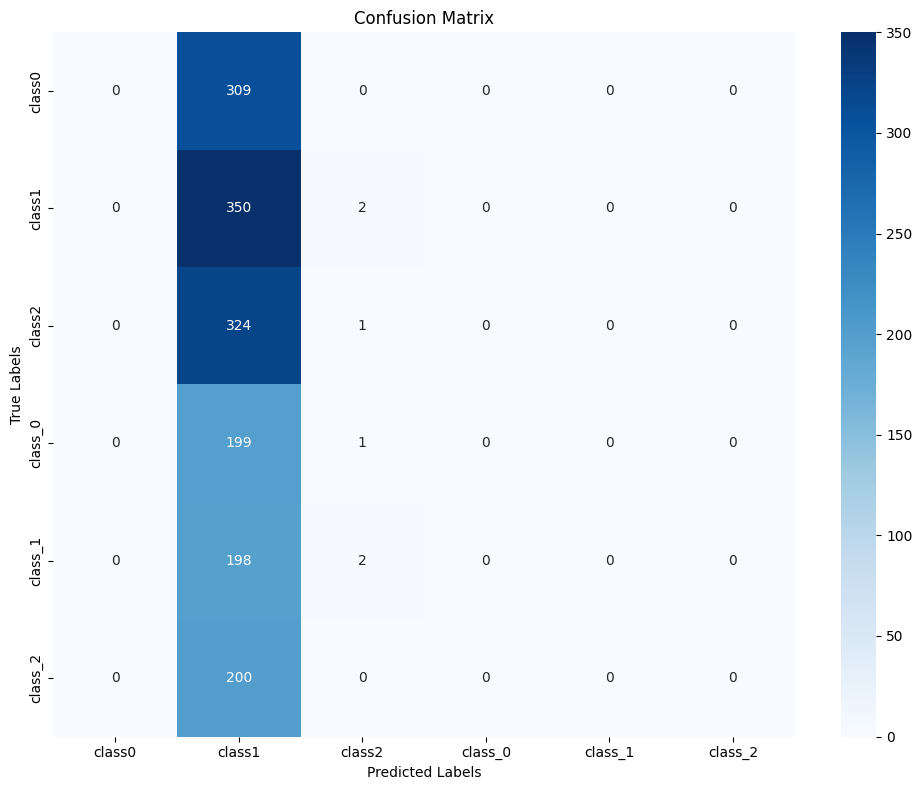

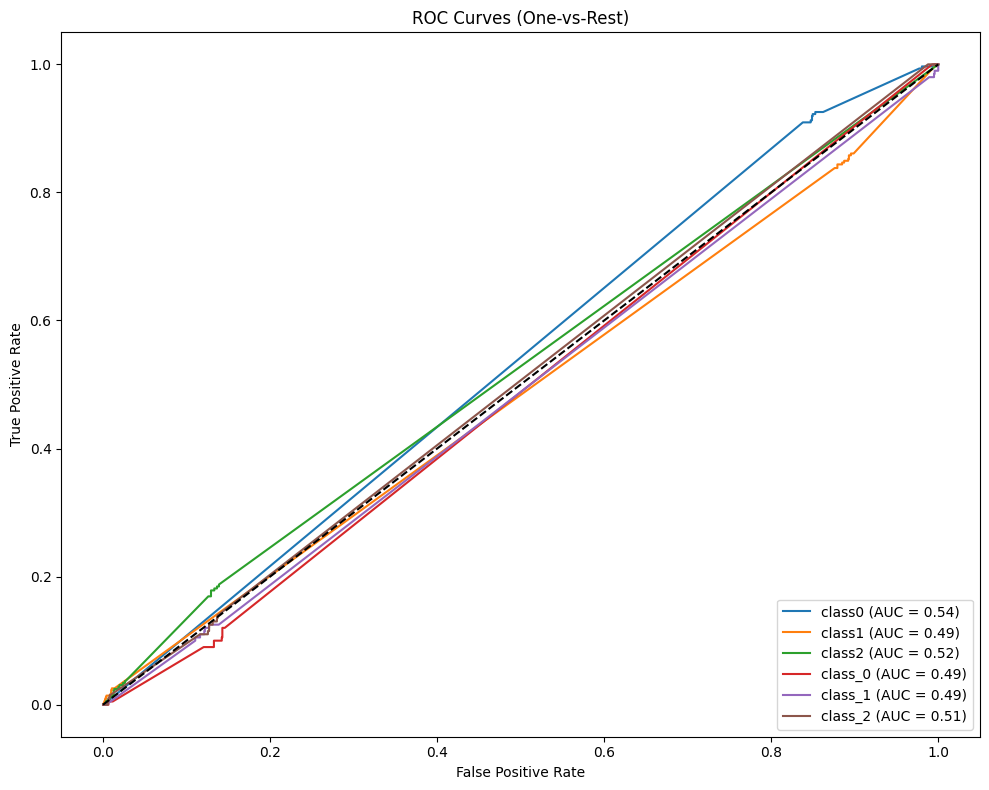


Evaluation results saved to evaluation_results_20241207_074939.txt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, device, class_names):
    print("\nSTAGE 5: EVALUATION")
    print("="*50)

    model.eval()
    all_preds = []
    all_labels = []
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))

    # Collect predictions
    print("Generating predictions...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate and display per-class accuracy
    print("\nPer-class Accuracy:")
    print("-" * 20)
    for i in range(len(class_names)):
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_names[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')

    # Classification Report
    print("\nDetailed Classification Report:")
    print("-" * 20)
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names,
                                 output_dict=True)

    # Print metrics for each class
    for class_name in class_names:
        metrics = report[class_name]
        print(f"\n{class_name}:")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

    # Overall metrics
    print("\nOverall Metrics:")
    print("-" * 20)
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Macro avg F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted avg F1-score: {report['weighted avg']['f1-score']:.4f}")

    # Confusion Matrix
    print("\nGenerating Confusion Matrix...")
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    # Calculate and plot ROC curve for multiclass
    if len(class_names) > 2:
        # Get probabilities for ROC curve
        all_probs = []
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())

        all_probs = np.array(all_probs)

        # Plot ROC curves
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Save evaluation results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results = {
        'confusion_matrix': cm,
        'classification_report': report,
        'per_class_accuracy': {
            class_names[i]: 100 * class_correct[i] / class_total[i]
            for i in range(len(class_names))
        }
    }

    # Save results to file
    results_filename = f'evaluation_results_{timestamp}.txt'
    with open(results_filename, 'w') as f:
        f.write("Evaluation Results\n")
        f.write("="*50 + "\n\n")

        f.write("Per-class Accuracy:\n")
        for i in range(len(class_names)):
            accuracy = 100 * class_correct[i] / class_total[i]
            f.write(f'{class_names[i]}: {accuracy:.2f}%\n')

        f.write("\nClassification Report:\n")
        f.write(classification_report(all_labels, all_preds, target_names=class_names))

        f.write("\nConfusion Matrix:\n")
        f.write(str(cm))

    print(f"\nEvaluation results saved to {results_filename}")

    return results

model = model.to(device)
evaluation_report = evaluate_model(model, test_loader, device, class_names)

## Wihtout synthetic images data

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

# Set paths
original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'
class SkinDiseaseDataset(Dataset):
    def __init__(self, files:[], labels: [], transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = torch.zeros((3, 300, 300))

        return image, label

In [ ]:
def load_and_split_data(original_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_files.extend(files)
        all_labels.extend([class_folder] * len(files))
        print(f"Loaded {len(files)} images from {class_folder}")

    # Show class distribution
    class_dist = {cls: all_labels.count(cls) for cls in set(all_labels)}
    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"{cls}: {count} images")

    # Encode labels
    unique_classes = sorted(set(all_labels))
    label_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    encoded_labels = [label_to_idx[label] for label in all_labels]

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, encoded_labels, test_size=test_size, random_state=42, stratify=encoded_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, unique_classes

# Example usage:
train_files, test_files, train_labels, test_labels, class_names = load_and_split_data(original_dataset_path)


STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class0
Loaded 1757 images from class1
Loaded 1625 images from class2

Class distribution:
class2: 1625 images
class1: 1757 images
class0: 1544 images

Split complete:
Train samples: 3940
Test samples: 986


In [ ]:
def get_dataloaders(train_files, test_files, train_labels, test_labels,
                    img_size=(224, 224), batch_size=32):
    print("\nSTAGE 2: DATA LOADING AND AUGMENTATION")
    print("="*50)

    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {len(train_loader)}")

    return train_loader, test_loader

# Create dataloaders
train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)


STAGE 2: DATA LOADING AND AUGMENTATION
Batch size: 32
Steps per epoch: 124


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        print("\nSTAGE 3: MODEL ARCHITECTURE")
        print("="*50)

        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        # Print model summary
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Statistics:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x

# Setup model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


STAGE 3: MODEL ARCHITECTURE

Model Statistics:
Total parameters: 419,933,507
Trainable parameters: 419,933,507


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, device, epochs=50):
    print("\nSTAGE 4: TRAINING")
    print("="*50)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    model = model.to(device)
    print(f"Model moved to {device}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                print(f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.2f}%")
            torch.save(model.state_dict(), 'best_cnn_model.pth')

    return history

# Train the model
history = train_model(model, train_loader, test_loader, criterion,
                     optimizer, scheduler, device)


STAGE 4: TRAINING
Model moved to cuda

Epoch 1/50
--------------------
Batch: 0/124 | Loss: 1.1166
Batch: 20/124 | Loss: 2.7098
Batch: 40/124 | Loss: 1.1656
Batch: 60/124 | Loss: 1.5713
Batch: 80/124 | Loss: 2.1613
Batch: 100/124 | Loss: 1.1977
Batch: 120/124 | Loss: 1.3615

Epoch Summary:
Train Loss: 6.6827 | Train Acc: 33.02%
Val Loss: 1.1301 | Val Acc: 32.15%
New best validation accuracy: 32.15%

Epoch 2/50
--------------------
Batch: 0/124 | Loss: 1.0683
Batch: 20/124 | Loss: 1.2997
Batch: 40/124 | Loss: 1.1909
Batch: 60/124 | Loss: 1.1196
Batch: 80/124 | Loss: 1.1056
Batch: 100/124 | Loss: 1.1293
Batch: 120/124 | Loss: 1.1300

Epoch Summary:
Train Loss: 1.1228 | Train Acc: 34.52%
Val Loss: 1.2394 | Val Acc: 35.70%
New best validation accuracy: 35.70%

Epoch 3/50
--------------------
Batch: 0/124 | Loss: 1.1084
Batch: 20/124 | Loss: 1.1762
Batch: 40/124 | Loss: 1.2061
Batch: 60/124 | Loss: 1.0849
Batch: 80/124 | Loss: 1.0709
Batch: 100/124 | Loss: 1.0619
Batch: 120/124 | Loss: 1.0


STAGE 5: EVALUATION
Generating predictions...

Per-class Accuracy:
--------------------
class0: 61.49% (190/309)
class1: 43.47% (153/352)
class2: 43.38% (141/325)

Detailed Classification Report:
--------------------

class0:
Precision: 0.5263
Recall: 0.6149
F1-score: 0.5672
Support: 309.0

class1:
Precision: 0.4146
Recall: 0.4347
F1-score: 0.4244
Support: 352.0

class2:
Precision: 0.5508
Recall: 0.4338
F1-score: 0.4854
Support: 325.0

Overall Metrics:
--------------------
Accuracy: 0.4909
Macro avg F1-score: 0.4923
Weighted avg F1-score: 0.4892

Generating Confusion Matrix...


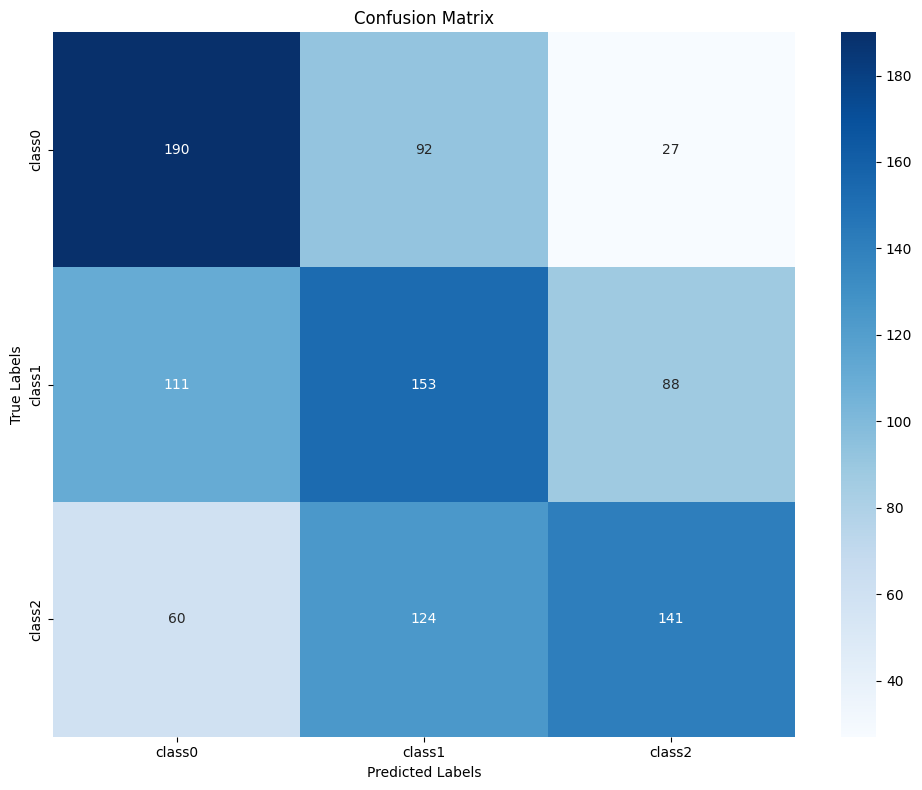

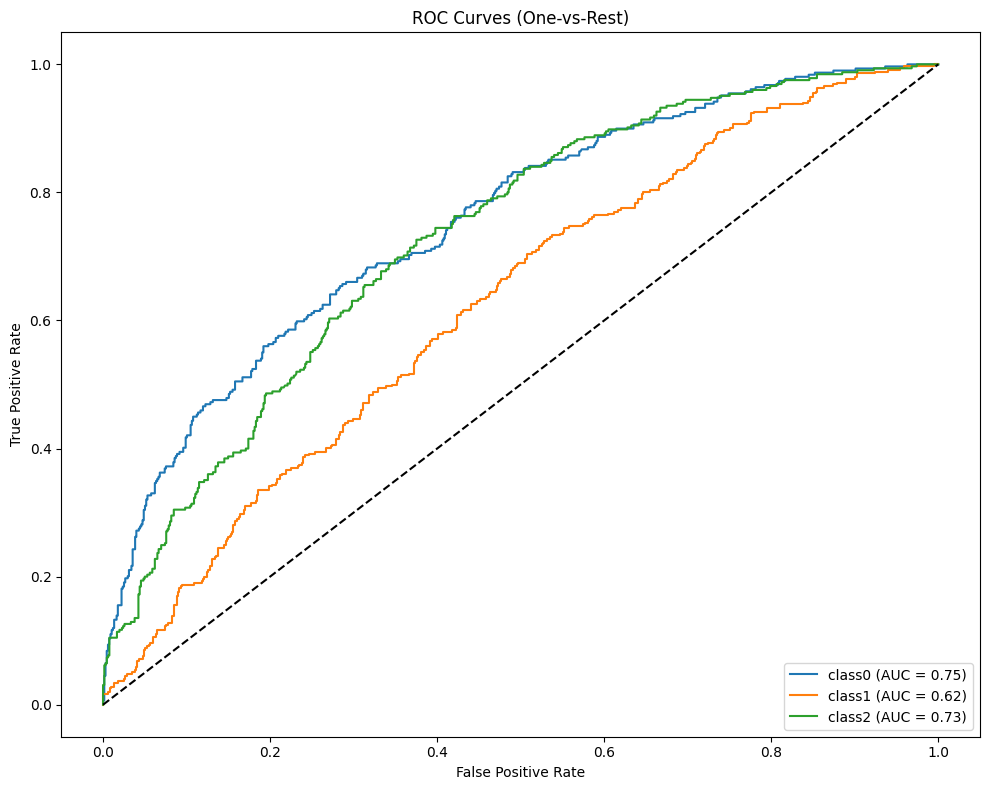


Evaluation results saved to evaluation_results_20241209_042427.txt


In [ ]:
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, device, class_names):
    print("\nSTAGE 5: EVALUATION")
    print("="*50)

    model.eval()
    all_preds = []
    all_labels = []
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))

    # Collect predictions
    print("Generating predictions...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate and display per-class accuracy
    print("\nPer-class Accuracy:")
    print("-" * 20)
    for i in range(len(class_names)):
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_names[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')

    # Classification Report
    print("\nDetailed Classification Report:")
    print("-" * 20)
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names,
                                 output_dict=True)

    # Print metrics for each class
    for class_name in class_names:
        metrics = report[class_name]
        print(f"\n{class_name}:")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

    # Overall metrics
    print("\nOverall Metrics:")
    print("-" * 20)
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Macro avg F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted avg F1-score: {report['weighted avg']['f1-score']:.4f}")

    # Confusion Matrix
    print("\nGenerating Confusion Matrix...")
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    # Calculate and plot ROC curve for multiclass
    if len(class_names) > 2:
        # Get probabilities for ROC curve
        all_probs = []
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())

        all_probs = np.array(all_probs)

        # Plot ROC curves
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Save evaluation results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results = {
        'confusion_matrix': cm,
        'classification_report': report,
        'per_class_accuracy': {
            class_names[i]: 100 * class_correct[i] / class_total[i]
            for i in range(len(class_names))
        }
    }

    # Save results to file
    results_filename = f'evaluation_results_{timestamp}.txt'
    with open(results_filename, 'w') as f:
        f.write("Evaluation Results\n")
        f.write("="*50 + "\n\n")

        f.write("Per-class Accuracy:\n")
        for i in range(len(class_names)):
            accuracy = 100 * class_correct[i] / class_total[i]
            f.write(f'{class_names[i]}: {accuracy:.2f}%\n')

        f.write("\nClassification Report:\n")
        f.write(classification_report(all_labels, all_preds, target_names=class_names))

        f.write("\nConfusion Matrix:\n")
        f.write(str(cm))

    print(f"\nEvaluation results saved to {results_filename}")

    return results

model = model.to(device)
evaluation_report = evaluate_model(model, test_loader, device, class_names)

In [ ]:
######################################################################################Finished###############
#############################################################################################################
######################## FInished ###########################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime
from torch.optim.lr_scheduler import OneCycleLR

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

class SkinDiseaseDataset(Dataset):
    def __init__(self, files: List[str], labels: List[int], transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = torch.zeros((3, 300, 300))

        return image, label
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    # Create a mapping for class normalization
    class_mapping = {
        "class0": 0, "class_0": 0,  # All class0/class_0 -> 0
        "class1": 1, "class_1": 1,  # All class1/class_1 -> 1
        "class2": 2, "class_2": 2   # All class2/class_2 -> 2
    }

    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping[class_folder]

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} images from class {normalized_label}")

    # Load GAN-generated images
    print("\nLoading GAN-generated images...")
    for class_folder in os.listdir(generated_path):
        if class_folder.endswith('_samples_grid.png'):  # Skip grid images
            continue

        gan_path = os.path.join(generated_path, class_folder)
        if not os.path.isdir(gan_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping[class_folder]

        files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} synthetic images for class {normalized_label}")

    # Show class distribution
    class_dist = {f"Class {cls}": all_labels.count(cls) for cls in set(all_labels)}
    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"{cls}: {count} images")

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, len(set(all_labels))

train_files, test_files, train_labels, test_labels, num_classes = load_and_split_data(original_dataset_path, gan_generated_path)
def get_dataloaders(train_files, test_files, train_labels, test_labels,
                    img_size=(300, 300), batch_size=32):
    print("\nSTAGE 2: DATA LOADING AND AUGMENTATION")
    print("="*50)

    transform_train = transforms.Compose([
    transforms.Resize((400, 400)),  # Larger initial size
    transforms.RandomResizedCrop(300, scale=(0.85, 1.0)),  # Less aggressive crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Less rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Milder color jitter
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Milder affine
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    transform_test = transforms.Compose([
    transforms.Resize((400, 400)),  # Match training size
    transforms.CenterCrop(300),     # Match training crop size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match training normalization
])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {len(train_loader)}")

    return train_loader, test_loader

# Create dataloaders

# train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)
def get_model(num_classes):
    model = efficientnet_b5(weights='IMAGENET1K_V1')

    # Freeze only first couple layers
    for param in model.features[:2].parameters():
        param.requires_grad = False

    in_features = model._modules['classifier'][1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(1024, num_classes)
    )
    return model

# Setup model and training components


def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# In training loop:
# mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
# outputs = model(mixed_images)
# loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    # Create a mapping for class normalization
    class_mapping = {
        "class0": 0, "class_0": 0,  # All class0/class_0 -> 0
        "class1": 1, "class_1": 1,  # All class1/class_1 -> 1
        "class2": 2, "class_2": 2   # All class2/class_2 -> 2
    }

    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping.get(class_folder)
        if normalized_label is None:
            continue

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} images from class {normalized_label}")

    # Load GAN-generated images
    print("\nLoading GAN-generated images...")
    for class_folder in os.listdir(generated_path):
        if class_folder.endswith('_samples_grid.png'):  # Skip grid images
            continue

        gan_path = os.path.join(generated_path, class_folder)
        if not os.path.isdir(gan_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping.get(class_folder)
        if normalized_label is None:
            continue

        files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)
                if f.endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} synthetic images for class {normalized_label}")

    # Verify we have files
    if len(all_files) == 0:
        raise ValueError("No image files found in the specified directories")

    # Calculate class distribution
    class_counts = [all_labels.count(i) for i in range(3)]  # We know we have 3 classes
    class_dist = {i: count for i, count in enumerate(class_counts)}

    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"Class {cls}: {count} images")

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, len(set(all_labels)), class_dist

# When calling the function:
train_files, test_files, train_labels, test_labels, num_classes, class_dist = load_and_split_data(
    original_dataset_path, gan_generated_path
)

# Now we can use class_dist for creating class weights
class_counts = [class_dist[i] for i in range(num_classes)]
#class_weights = torch.FloatTensor([sum(class_counts)/count for count in class_counts]).to(device)
# Calculate class weights based on the distribution
total_samples = sum(class_dist.values())
class_weights = torch.FloatTensor([
    total_samples / (3 * class_dist[0]),  # Multiply by number of classes
    total_samples / (3 * class_dist[1]),
    total_samples / (3 * class_dist[2])
]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
# Setup model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=num_classes)

# Initialize weights for new layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Changed to xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.classifier.apply(init_weights)

# After getting class distribution
# class_counts = [class_dist[f"Class {i}"] for i in range(num_classes)]
# class_weights = torch.FloatTensor([sum(class_counts)/count for count in class_counts]).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Split parameters into different groups for different learning rates
encoder_params = list(model.features.parameters())
classifier_params = list(model.classifier.parameters())

optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': 5e-5},  # Lower LR for pretrained layers
    {'params': classifier_params, 'lr': 5e-4}  # Higher LR for new layers
], weight_decay=0.01)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[5e-4, 5e-3],  # Different max LRs
    epochs=60,
    steps_per_epoch=len(train_loader),
    pct_start=0.2
)

def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, device, epochs=60):
    print("\nSTAGE 4: TRAINING")
    print("="*50)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    model = model.to(device)
    print(f"\nModel moved to {device}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Mixup augmentation
            mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)

            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

            # For accuracy calculation with mixup
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (lam * predicted.eq(targets_a).sum().float()
                       + (1 - lam) * predicted.eq(targets_b).sum().float())

            if batch_idx % 20 == 0:
                print(f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.2f}%")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
            }, 'best_model.pth')

    return history

# Train the model
history = train_model(model, train_loader, test_loader, criterion,
                     optimizer, scheduler, device)


STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class 0
Loaded 1757 images from class 1
Loaded 1625 images from class 2

Loading GAN-generated images...
Loaded 1000 synthetic images for class 2
Loaded 1000 synthetic images for class 1
Loaded 1000 synthetic images for class 0

Class distribution:
Class 0: 2544 images
Class 1: 2757 images
Class 2: 2625 images

Split complete:
Train samples: 6340
Test samples: 1586

STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class 0
Loaded 1757 images from class 1
Loaded 1625 images from class 2

Loading GAN-generated images...
Loaded 1000 synthetic images for class 2
Loaded 1000 synthetic images for class 1
Loaded 1000 synthetic images for class 0

Class distribution:
Class 0: 2544 images
Class 1: 2757 images
Class 2: 2625 images

Split complete:
Train samples: 6340
Test samples: 1586

STAGE 4: TRAINING

Model moved to cuda

Epoch 1/60
--------------------
Batch: 0/199 | Loss: 1.6820

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b5
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import datetime
from torch.optim.lr_scheduler import OneCycleLR

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

class SkinDiseaseDataset(Dataset):
    def __init__(self, files: List[str], labels: List[int], transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = torch.zeros((3, 300, 300))

        return image, label
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    # Create a mapping for class normalization
    class_mapping = {
        "class0": 0, "class_0": 0,  # All class0/class_0 -> 0
        "class1": 1, "class_1": 1,  # All class1/class_1 -> 1
        "class2": 2, "class_2": 2   # All class2/class_2 -> 2
    }

    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping[class_folder]

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} images from class {normalized_label}")

    # Load GAN-generated images
    print("\nLoading GAN-generated images...")
    for class_folder in os.listdir(generated_path):
        if class_folder.endswith('_samples_grid.png'):  # Skip grid images
            continue

        gan_path = os.path.join(generated_path, class_folder)
        if not os.path.isdir(gan_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping[class_folder]

        files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} synthetic images for class {normalized_label}")

    # Show class distribution
    class_dist = {f"Class {cls}": all_labels.count(cls) for cls in set(all_labels)}
    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"{cls}: {count} images")

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, len(set(all_labels))

train_files, test_files, train_labels, test_labels, num_classes = load_and_split_data(original_dataset_path, gan_generated_path)
def get_dataloaders(train_files, test_files, train_labels, test_labels,
                    img_size=(300, 300), batch_size=128):  # Increased from 32 to 128

    transform_train = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomResizedCrop(300, scale=(0.9, 1.0)),  # Less aggressive crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Reduced rotation
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    transform_test = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=8, pin_memory=True)  # Increased workers and added pin_memory
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=8, pin_memory=True)

    return train_loader, test_loader

# Use a larger model with more capacity
def get_model(num_classes):
    model = efficientnet_b5(weights='IMAGENET1K_V1')

    # Freeze more layers initially
    for param in model.features[:3].parameters():
        param.requires_grad = False

    in_features = model._modules['classifier'][1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),  # Increased dropout
        nn.Linear(in_features, 1024),  # Reduced layer size
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, num_classes)
    )
    return model

# Setup model and training components


def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# In training loop:
# mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
# outputs = model(mixed_images)
# loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
def load_and_split_data(original_path, generated_path, test_size=0.2):
    print("\nSTAGE 1: DATA PREPROCESSING")
    print("="*50)

    # Create a mapping for class normalization
    class_mapping = {
        "class0": 0, "class_0": 0,  # All class0/class_0 -> 0
        "class1": 1, "class_1": 1,  # All class1/class_1 -> 1
        "class2": 2, "class_2": 2   # All class2/class_2 -> 2
    }

    all_files = []
    all_labels = []

    # Load original dataset
    print("\nLoading original dataset...")
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping.get(class_folder)
        if normalized_label is None:
            continue

        files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} images from class {normalized_label}")

    # Load GAN-generated images
    print("\nLoading GAN-generated images...")
    for class_folder in os.listdir(generated_path):
        if class_folder.endswith('_samples_grid.png'):  # Skip grid images
            continue

        gan_path = os.path.join(generated_path, class_folder)
        if not os.path.isdir(gan_path):
            continue

        # Map the class name to normalized label
        normalized_label = class_mapping.get(class_folder)
        if normalized_label is None:
            continue

        files = [os.path.join(gan_path, f) for f in os.listdir(gan_path)
                if f.endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend(files)
        all_labels.extend([normalized_label] * len(files))
        print(f"Loaded {len(files)} synthetic images for class {normalized_label}")

    # Verify we have files
    if len(all_files) == 0:
        raise ValueError("No image files found in the specified directories")

    # Calculate class distribution
    class_counts = [all_labels.count(i) for i in range(3)]  # We know we have 3 classes
    class_dist = {i: count for i, count in enumerate(class_counts)}

    print("\nClass distribution:")
    for cls, count in class_dist.items():
        print(f"Class {cls}: {count} images")

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )

    print(f"\nSplit complete:")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")

    return train_files, test_files, train_labels, test_labels, len(set(all_labels)), class_dist

# When calling the function:
train_files, test_files, train_labels, test_labels, num_classes, class_dist = load_and_split_data(
    original_dataset_path, gan_generated_path
)
device='cuda'
# Now we can use class_dist for creating class weights
class_counts = [class_dist[i] for i in range(num_classes)]
#class_weights = torch.FloatTensor([sum(class_counts)/count for count in class_counts]).to(device)
# Calculate class weights based on the distribution
total_samples = sum(class_dist.values())
class_weights = torch.FloatTensor([
    total_samples / (3 * class_dist[0]),  # Multiply by number of classes
    total_samples / (3 * class_dist[1]),
    total_samples / (3 * class_dist[2])
]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
# Setup model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=num_classes)

# Initialize weights for new layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Changed to xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.classifier.apply(init_weights)

# After getting class distribution
# class_counts = [class_dist[f"Class {i}"] for i in range(num_classes)]
# class_weights = torch.FloatTensor([sum(class_counts)/count for count in class_counts]).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Split parameters into different groups for different learning rates
#Optimizer with higher learning rates
total_samples = sum(class_dist.values())
class_weights = torch.FloatTensor([
    total_samples / (3 * class_dist[0]),
    total_samples / (3 * class_dist[1]),
    total_samples / (3 * class_dist[2])
]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)

# Split parameters into groups
encoder_params = list(model.features.parameters())
classifier_params = list(model.classifier.parameters())

optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': 1e-5},  # Lower initial LR
    {'params': classifier_params, 'lr': 1e-4}  # Lower initial LR
], weight_decay=0.02)  # Increased weight decay

scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-4, 1e-3],  # Lower max LRs
    epochs=60,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # Longer warmup
    div_factor=10.0,  # Less aggressive LR range
    final_div_factor=100.0
)

# Add validate function before train_model
def validate(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return val_loss / len(test_loader), 100. * correct / total

# Modified training loop with mixed precision
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, device, epochs=60):
    print("\nSTAGE 4: TRAINING")
    print("="*50)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    model = model.to(device)
    print(f"\nModel moved to {device}")

    # Initialize the scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Mixed precision training
            with torch.cuda.amp.autocast():
                            mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.1)  # Reduced alpha
                            outputs = model(mixed_images)
                            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()

            # Scale the loss and perform backward pass
            scaler.scale(loss).backward()

            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Reduced clip value


            # Optimizer step with scaling
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            running_loss += loss.item()

            # Accuracy calculation with mixup
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (lam * predicted.eq(targets_a).sum().float()
                       + (1 - lam) * predicted.eq(targets_b).sum().float())

            if batch_idx % 20 == 0:
                print(f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.2f}%")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
            }, 'best_model.pth')

    return history
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
# Train the model
history = train_model(model, train_loader, test_loader, criterion,
                     optimizer, scheduler, device)

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class 0
Loaded 1757 images from class 1
Loaded 1625 images from class 2

Loading GAN-generated images...
Loaded 1000 synthetic images for class 2
Loaded 1000 synthetic images for class 1
Loaded 1000 synthetic images for class 0

Class distribution:
Class 0: 2544 images
Class 1: 2757 images
Class 2: 2625 images

Split complete:
Train samples: 6340
Test samples: 1586

STAGE 1: DATA PREPROCESSING

Loading original dataset...
Loaded 1544 images from class 0
Loaded 1757 images from class 1
Loaded 1625 images from class 2

Loading GAN-generated images...
Loaded 1000 synthetic images for class 2
Loaded 1000 synthetic images for class 1
Loaded 1000 synthetic images for class 0

Class distribution:
Class 0: 2544 images
Class 1: 2757 images
Class 2: 2625 images

Split complete:
Train samples: 6340
Test samples: 1586

STAGE 4: TRAINING

Model moved to cuda

Epoch 1/60
--------------------


<ipython-input-4-46f901a5a61a>:365: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-4-46f901a5a61a>:381: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Batch: 0/50 | Loss: 1.4399
Batch: 20/50 | Loss: 1.3957
Batch: 40/50 | Loss: 1.4198

Epoch Summary:
Train Loss: 1.3691 | Train Acc: 34.69%
Val Loss: 1.1395 | Val Acc: 38.08%
New best validation accuracy: 38.08%

Epoch 2/60
--------------------
Batch: 0/50 | Loss: 1.3670
Batch: 20/50 | Loss: 1.2984
Batch: 40/50 | Loss: 1.2378

Epoch Summary:
Train Loss: 1.3031 | Train Acc: 37.26%
Val Loss: 1.0964 | Val Acc: 43.82%
New best validation accuracy: 43.82%

Epoch 3/60
--------------------
Batch: 0/50 | Loss: 1.1796
Batch: 20/50 | Loss: 1.2921
Batch: 40/50 | Loss: 1.2437

Epoch Summary:
Train Loss: 1.2515 | Train Acc: 39.68%
Val Loss: 1.0825 | Val Acc: 44.89%
New best validation accuracy: 44.89%

Epoch 4/60
--------------------
Batch: 0/50 | Loss: 1.1941
Batch: 20/50 | Loss: 1.1889
Batch: 40/50 | Loss: 1.2822

Epoch Summary:
Train Loss: 1.2300 | Train Acc: 39.51%
Val Loss: 1.0810 | Val Acc: 44.01%

Epoch 5/60
--------------------
Batch: 0/50 | Loss: 1.1318
Batch: 20/50 | Loss: 1.2892
Batch: 40/

In [ ]:
##########################################################

In [ ]:
from torchvision.models import efficientnet_b5
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

original_dataset_path = '/content/drive/MyDrive/Thesis/Dataset'
gan_generated_path = '/content/drive/MyDrive/Thesis/synthetic_images'

# Mapping between folder names
folder_mapping = {"class_0": "class0", "class_1": "class1", "class_2": "class2"}

# Step 1: Combine and Split Data
def load_and_split_data(original_path, generated_path, test_size=0.2):
    all_files = []
    all_labels = []

    # Process each class folder in the original dataset
    for class_folder in os.listdir(original_path):
        class_path = os.path.join(original_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Handle folder mapping
        mapped_folder = folder_mapping.get(class_folder, class_folder)

        # Load images
        for img in os.listdir(class_path):
            all_files.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

        # Load GAN-generated images
        gan_class_path = os.path.join(generated_path, mapped_folder)
        if os.path.exists(gan_class_path):
            for img in os.listdir(gan_class_path):
                all_files.append(os.path.join(gan_class_path, img))
                all_labels.append(class_folder)

    # Encode labels
    unique_classes = sorted(set(all_labels))
    label_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    encoded_labels = [label_to_idx[label] for label in all_labels]

    # Split into train and test
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, encoded_labels, test_size=test_size, random_state=42
    )

    return train_files, test_files, train_labels, test_labels, unique_classes


# Step 2: Define Dataset Class
class SkinDiseaseDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# Step 3: Prepare Dataloaders
def get_dataloaders(train_files, test_files, train_labels, test_labels, img_size=(300, 300), batch_size=32):
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    train_dataset = SkinDiseaseDataset(train_files, train_labels, transform=transform_train)
    test_dataset = SkinDiseaseDataset(test_files, test_labels, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader


# Define Model
def get_model(num_classes):
    model = efficientnet_b5(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Main Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=100):
    model.to(device)
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_acc = 100. * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()

# Initialize
model = get_model(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

train_files, test_files, train_labels, test_labels, unique_classes = load_and_split_data(
    original_dataset_path, gan_generated_path
)
# Prepare DataLoaders
train_loader, test_loader = get_dataloaders(train_files, test_files, train_labels, test_labels)


train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device="cuda", epochs=100)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 215MB/s]


Epoch 1/100 - Train Loss: 1.0801, Train Acc: 39.13%
Epoch 1/100 - Val Loss: 1.0392, Val Acc: 47.10%
Epoch 2/100 - Train Loss: 1.0391, Train Acc: 46.92%
Epoch 2/100 - Val Loss: 1.0314, Val Acc: 49.05%
Epoch 3/100 - Train Loss: 1.0139, Train Acc: 48.41%
Epoch 3/100 - Val Loss: 0.9802, Val Acc: 51.64%
Epoch 4/100 - Train Loss: 0.9871, Train Acc: 50.84%
Epoch 4/100 - Val Loss: 0.9655, Val Acc: 52.77%
Epoch 5/100 - Train Loss: 0.9581, Train Acc: 52.93%
Epoch 5/100 - Val Loss: 0.9730, Val Acc: 53.59%
Epoch 6/100 - Train Loss: 0.9343, Train Acc: 54.29%
Epoch 6/100 - Val Loss: 0.9454, Val Acc: 55.61%
Epoch 7/100 - Train Loss: 0.9190, Train Acc: 55.03%
Epoch 7/100 - Val Loss: 0.9413, Val Acc: 56.43%
Epoch 8/100 - Train Loss: 0.8837, Train Acc: 57.35%
Epoch 8/100 - Val Loss: 0.9341, Val Acc: 55.93%
Epoch 9/100 - Train Loss: 0.8842, Train Acc: 57.60%
Epoch 9/100 - Val Loss: 0.9370, Val Acc: 56.68%
Epoch 10/100 - Train Loss: 0.8764, Train Acc: 58.63%
Epoch 10/100 - Val Loss: 0.9362, Val Acc: 56.62

KeyboardInterrupt: 

Epoch 1/100 - Train Loss: 1.0674, Train Acc: 41.19%
Epoch 1/100 - Val Loss: 1.0845, Val Acc: 41.86%
Epoch 2/100 - Train Loss: 0.9752, Train Acc: 51.88%
Epoch 2/100 - Val Loss: 0.8619, Val Acc: 62.02%
Epoch 3/100 - Train Loss: 0.8878, Train Acc: 59.53%
Epoch 3/100 - Val Loss: 0.7596, Val Acc: 65.67%
Epoch 4/100 - Train Loss: 0.8079, Train Acc: 63.77%
Epoch 4/100 - Val Loss: 0.7188, Val Acc: 69.55%
Epoch 5/100 - Train Loss: 0.7696, Train Acc: 65.44%
Epoch 5/100 - Val Loss: 0.7090, Val Acc: 67.66%
Epoch 6/100 - Train Loss: 0.7515, Train Acc: 66.46%
Epoch 6/100 - Val Loss: 0.6411, Val Acc: 73.20%
Epoch 7/100 - Train Loss: 0.6917, Train Acc: 70.15%
Epoch 7/100 - Val Loss: 0.6379, Val Acc: 73.31%
Epoch 8/100 - Train Loss: 0.6829, Train Acc: 70.65%
Epoch 8/100 - Val Loss: 0.6305, Val Acc: 73.09%
Epoch 9/100 - Train Loss: 0.6489, Train Acc: 71.84%
Epoch 9/100 - Val Loss: 0.6154, Val Acc: 73.75%
Epoch 10/100 - Train Loss: 0.6580, Train Acc: 72.78%
Epoch 10/100 - Val Loss: 0.6103, Val Acc: 74.09%
Epoch 11/100 - Train Loss: 0.6506, Train Acc: 72.12%
Epoch 11/100 - Val Loss: 0.6119, Val Acc: 73.98%
Epoch 12/100 - Train Loss: 0.6520, Train Acc: 71.98%
Epoch 12/100 - Val Loss: 0.6119, Val Acc: 73.86%
Epoch 13/100 - Train Loss: 0.6689, Train Acc: 71.84%
Epoch 13/100 - Val Loss: 0.6101, Val Acc: 74.64%
Epoch 14/100 - Train Loss: 0.6371, Train Acc: 72.64%
Epoch 14/100 - Val Loss: 0.5973, Val Acc: 76.08%
Epoch 15/100 - Train Loss: 0.6193, Train Acc: 73.12%
Epoch 15/100 - Val Loss: 0.5934, Val Acc: 75.97%
Epoch 16/100 - Train Loss: 0.6016, Train Acc: 75.19%
Epoch 16/100 - Val Loss: 0.6057, Val Acc: 76.19%
Epoch 17/100 - Train Loss: 0.6261, Train Acc: 73.12%
Epoch 17/100 - Val Loss: 0.5903, Val Acc: 76.19%
Epoch 18/100 - Train Loss: 0.5931, Train Acc: 75.22%
Epoch 18/100 - Val Loss: 0.5914, Val Acc: 77.52%
Epoch 19/100 - Train Loss: 0.5730, Train Acc: 75.33%
Epoch 19/100 - Val Loss: 0.5556, Val Acc: 78.96%
Epoch 20/100 - Train Loss: 0.5513, Train Acc: 77.30%
Epoch 20/100 - Val Loss: 0.5692, Val Acc: 78.63%
Epoch 21/100 - Train Loss: 0.5176, Train Acc: 78.66%
Epoch 21/100 - Val Loss: 0.5972, Val Acc: 79.51%
Epoch 22/100 - Train Loss: 0.5032, Train Acc: 79.16%
Epoch 22/100 - Val Loss: 0.5791, Val Acc: 79.62%
Epoch 23/100 - Train Loss: 0.4762, Train Acc: 80.29%
Epoch 23/100 - Val Loss: 0.5444, Val Acc: 80.62%
Epoch 24/100 - Train Loss: 0.4517, Train Acc: 81.35%
Epoch 24/100 - Val Loss: 0.5267, Val Acc: 82.50%
Epoch 25/100 - Train Loss: 0.4269, Train Acc: 82.73%
Epoch 25/100 - Val Loss: 0.5635, Val Acc: 81.84%
Epoch 26/100 - Train Loss: 0.4042, Train Acc: 83.45%
Epoch 26/100 - Val Loss: 0.5489, Val Acc: 82.72%
Epoch 27/100 - Train Loss: 0.3945, Train Acc: 83.37%
Epoch 27/100 - Val Loss: 0.5268, Val Acc: 83.94%
Epoch 28/100 - Train Loss: 0.3600, Train Acc: 85.45%
Epoch 28/100 - Val Loss: 0.5369, Val Acc: 84.83%
Epoch 29/100 - Train Loss: 0.3533, Train Acc: 86.28%
Epoch 29/100 - Val Loss: 0.5309, Val Acc: 84.50%
Epoch 30/100 - Train Loss: 0.3426, Train Acc: 86.45%
Epoch 30/100 - Val Loss: 0.5291, Val Acc: 84.39%
Epoch 31/100 - Train Loss: 0.3447, Train Acc: 86.09%
Epoch 31/100 - Val Loss: 0.5304, Val Acc: 84.83%
Epoch 32/100 - Train Loss: 0.3512, Train Acc: 84.98%
Epoch 32/100 - Val Loss: 0.5288, Val Acc: 84.39%
Epoch 33/100 - Train Loss: 0.3392, Train Acc: 86.28%
Epoch 33/100 - Val Loss: 0.5314, Val Acc: 84.39%
Epoch 34/100 - Train Loss: 0.3334, Train Acc: 87.17%
Epoch 34/100 - Val Loss: 0.5324, Val Acc: 84.94%
Epoch 35/100 - Train Loss: 0.3349, Train Acc: 86.78%
Epoch 35/100 - Val Loss: 0.5534, Val Acc: 84.39%
Epoch 36/100 - Train Loss: 0.3403, Train Acc: 86.20%
Epoch 36/100 - Val Loss: 0.5344, Val Acc: 84.61%
Epoch 37/100 - Train Loss: 0.3540, Train Acc: 85.64%
Epoch 37/100 - Val Loss: 0.5519, Val Acc: 83.94%
Epoch 38/100 - Train Loss: 0.3529, Train Acc: 85.86%
Epoch 38/100 - Val Loss: 0.5896, Val Acc: 84.05%
Epoch 39/100 - Train Loss: 0.3358, Train Acc: 86.47%
Epoch 39/100 - Val Loss: 0.5981, Val Acc: 84.39%
Epoch 40/100 - Train Loss: 0.3586, Train Acc: 85.62%
Epoch 40/100 - Val Loss: 0.5406, Val Acc: 84.27%
Epoch 41/100 - Train Loss: 0.3462, Train Acc: 86.78%
Epoch 41/100 - Val Loss: 0.5792, Val Acc: 82.50%
Epoch 42/100 - Train Loss: 0.3327, Train Acc: 86.53%
Epoch 42/100 - Val Loss: 0.5896, Val Acc: 82.50%
Epoch 43/100 - Train Loss: 0.3144, Train Acc: 87.39%
Epoch 43/100 - Val Loss: 0.5936, Val Acc: 83.50%
Epoch 44/100 - Train Loss: 0.3125, Train Acc: 87.11%
Epoch 44/100 - Val Loss: 0.5998, Val Acc: 84.16%
Epoch 45/100 - Train Loss: 0.2766, Train Acc: 89.30%
Epoch 45/100 - Val Loss: 0.6153, Val Acc: 83.72%

In [ ]:
############################

In [ ]:
#######################
########################## Main ###################
############################

In [ ]:
sys.path.append('stylegan2-ada-pytorch')

In [ ]:
########################
####################################
##############################

In [ ]:
###################################################

In [ ]:
import torch

# Free up GPU memory
torch.cuda.empty_cache()

# Optional: Reset all CUDA memory allocations
torch.cuda.memory_reserved()
torch.cuda.memory_allocated()
torch.cuda.memory_cached()

# Optionally, force garbage collection to release unreferenced memory
import gc
gc.collect()

print("GPU memory cleared in PyTorch!")

import torch

# Free up GPU memory
torch.cuda.empty_cache()

# Optional: Force garbage collection
import gc
gc.collect()

print("GPU memory cleared in PyTorch!")


<ipython-input-171-35658f102ee4>:9: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  torch.cuda.memory_cached()


GPU memory cleared in PyTorch!
GPU memory cleared in PyTorch!


In [ ]:
import torch

# Free up GPU memory
torch.cuda.empty_cache()

# Optional: Reset all CUDA memory allocations
torch.cuda.memory_reserved()
torch.cuda.memory_allocated()
torch.cuda.memory_cached()

# Optionally, force garbage collection to release unreferenced memory
import gc
gc.collect()

print("GPU memory cleared in PyTorch!")


<ipython-input-172-da2feb0e232c>:9: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  torch.cuda.memory_cached()


GPU memory cleared in PyTorch!


In [ ]:
import tensorflow as tf

# Clear TensorFlow session to free memory
tf.keras.backend.clear_session()

# Optionally, reset GPU devices if possible
from numba import cuda
cuda.select_device(0)  # Replace '0' with your GPU ID
cuda.close()
print("GPU memory cleared in TensorFlow!")


GPU memory cleared in TensorFlow!
